In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pysindy as ps
from sklearn.metrics import mean_squared_error
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
import sys
sys.path.append("../../")

from src.utils.other import *
from src.utils.exp_utils import get_equations, update_equation_list
from src.utils.plotting import clear_ax_extra, draw_equations
from src.utils.model_utils import sindy_coeffs_stats

from src.utils.other import save_model
from src.trainer.baseline import log_losses, update_beta

from src.models.HyperNet import HyperNet
from src.utils.model_utils import library_size, sindy_library
from src.utils.model_utils import equation_sindy_library, sindy_coeffs_stats, get_equation

# Train

In [140]:
class LVDataset(Dataset):

    def __init__(self, args):
        self.x, self.dx = self.stochastic_simulate(timesteps=1000, dt=0.025,
                                              x0=4.0, y0=2.0, alpha=1.0,
                                              beta=1.0, delta=1.0, gamma=1.0,
                                              noise_mean=0.0, noise_scale=1.0)    
        self.x = torch.from_numpy(self.x)
        self.x_lib = sindy_library(self.x, args.poly_order,
                                   include_constant=args.include_constant,
                                   include_sine=args.include_sine,
                                   include_mult_sine=args.include_mult_sine)
        self.dx = torch.from_numpy(self.dx)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.x_lib[idx], self.dx[idx]
    
    def stochastic_derivative(self, x, y, alpha=1.0, beta=1.0, delta=1.0, gamma=1.0, noise_mean=0.0, noise_scale=1.0):
        dotx = x * alpha - beta * x * y #+ np.random.normal(noise_mean, noise_scale)
        doty = y * -delta + gamma * x * y #+ np.random.normal(noise_mean, noise_scale)
        return dotx, doty

    def stochastic_simulate(self, timesteps, dt, x0, y0, alpha, beta, delta, gamma, noise_mean, noise_scale):
        x, y = x0, y0
        Xs = [(x, y)]
        dXs = []
        for t in range(timesteps):
            dx, dy = self.stochastic_derivative(x, y, alpha, beta, delta, gamma, noise_mean, noise_scale)
            x, y = x + dx * dt, y + dy * dt
            Xs.append((x, y))
            dXs.append((dx, dy))
        return np.stack(Xs, axis=0)[:-1], np.stack(dXs, axis=0)
        

def load_data(args):
    # train and val data (using val as "test" data)
    return LVDataset(args)

In [141]:
b = load_data(args)

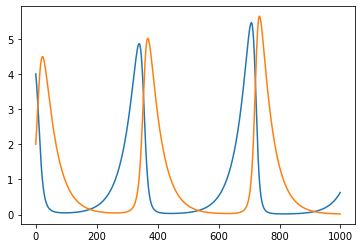

In [142]:
plt.plot(b.x)

In [29]:
b.x

tensor([[4.0000, 2.0000],
        [3.9679, 2.0374],
        [3.9076, 2.0962],
        ...,
        [   nan,    nan],
        [   nan,    nan],
        [   nan,    nan]], dtype=torch.float64)

In [143]:
class Net(nn.Module):
    def __init__(self, args):
        super(Net, self).__init__()
        
        self.z_dim = args.z_dim
        self.poly_order = args.poly_order
        self.noise_dim = args.noise_dim
        self.include_constant = args.include_constant
        self.include_sine = args.include_sine
        self.include_mult_sine=args.include_mult_sine
        self.statistic_batch_size = args.statistic_batch_size

        self.library_dim = library_size(self.z_dim, self.poly_order,
            include_constant=self.include_constant, use_sine=self.include_sine,
            use_mult_sine=self.include_mult_sine)
        self.hypernet = HyperNet(self.noise_dim, (self.library_dim, self.z_dim),
            [args.hidden_dim for _ in range(4)], norm=args.norm)
        self.threshold_mask = nn.Parameter(torch.ones(self.library_dim, self.z_dim),
            requires_grad=False)
    
        
    def forward(self, x_lib, device):
        x_lib = x_lib.type(torch.FloatTensor).to(device)
        sindy_coeffs = self.get_masked_coefficients(batch_size=x_lib.size(0), device=device)
        return self.dz(x_lib, sindy_coeffs), sindy_coeffs
    
    def sample_transition(self, n=None, batch_size=1, device='cpu'):
        return self.hypernet(n, batch_size, device=device)
    
    def dz(self, x_lib, sindy_coeffs):
        x_lib = x_lib.unsqueeze(1)
        return torch.bmm(x_lib, sindy_coeffs).squeeze(1)

    def sample_sindy_coeffs(self, n=None, batch_size=500, device=0):
        if n is None:
            n = torch.randn([batch_size, self.noise_dim], device=device)
        return self.sample_transition(n=n, batch_size=batch_size, device=device)

    def get_masked_coefficients(self, n=None, batch_size=500, device=0):
        return self.sample_sindy_coeffs(n, batch_size, device) * self.threshold_mask
    
    def sindy_library(self, x):
        return sindy_library(x, self.poly_order,
                             include_constant=self.include_constant,
                             include_sine=self.include_sine,
                             include_mult_sine=self.include_mult_sine)
    
    def kl(self, sindy_coeffs, num_samples=5, full_kernel=True):
        num_samples = sindy_coeffs.size(0)
    
        masked_coeffs = sindy_coeffs.reshape(num_samples, -1) # 250 x 60
        gen_weights = masked_coeffs.transpose(1, 0) # 60 x 250
        prior_samples = torch.randn_like(gen_weights)
        eye = torch.eye(num_samples, device=gen_weights.device) # 250 x 250
        wp_distances = (prior_samples.unsqueeze(2) - gen_weights.unsqueeze(1)) ** 2  # 60 x 250 x 250
        ww_distances = (gen_weights.unsqueeze(2) - gen_weights.unsqueeze(1)) ** 2    # 60 x 250 x 250
        
        # anything thresholded out to 0 should have 0 loss (so gradient doesn't flow)
        wp_distances = wp_distances * self.threshold_mask.reshape(-1, 1, 1)
        ww_distances = ww_distances * self.threshold_mask.reshape(-1, 1 ,1)
        
        wp_distances = torch.sqrt(torch.sum(wp_distances, 0) + 1e-8) # 250 x 250
        wp_dist = torch.min(wp_distances, 0)[0] # 250
        ww_distances = torch.sqrt(torch.sum(ww_distances, 0) + 1e-8) + eye * 1e10 # 250 x 250
        ww_dist = torch.min(ww_distances, 0)[0] # 250

        # mean over samples
        kl = torch.mean(torch.log(wp_dist / (ww_dist + 1e-8) + 1e-8))
        kl *= gen_weights.shape[0]
        kl += torch.log(torch.tensor(float(num_samples) / (num_samples - 1)))
        return kl


def train(net, optim, scheduler, cp_path, model_type, trainloader, board,
          dt, device, initial_epoch, epochs,
          checkpoint_interval, threshold_timer,
          weight_decay, threshold, beta): 

    thresh_mean = False
    for e in range(initial_epoch, epochs + initial_epoch):
        print(e, end=' ')
        # train mode
        net = net.train()
        
        recons, klds = 0, 0
        for i, (x, x_lib, x_dot) in enumerate(trainloader):
            x_dot = x_dot.type(torch.FloatTensor).to(device)
            recon, kld = train_step(net, optim, x_lib, x_dot, device, weight_decay, beta)
            recons += recon
            klds += kld
            
        if np.isnan(recons) or np.isinf(recons):
            print("NAN RECON")
            break

        # log losses
        log_losses(board, recons / len(trainloader), klds / len(trainloader), e)

        # eval mode for thresholding
        net = net.eval()

        # threshold
        if (e % threshold_timer == 0) and (e != 0):
            # EM threshold - threshold the deterministic coefs or the noise coefs
            update_threshold_mask(net, device, threshold)

        # save
        if (e + 1) % checkpoint_interval == 0:
            save_model(cp_path, net, optim, scheduler, e)

        scheduler.step()

    save_model(cp_path, net, optim, scheduler, e)

    return net, optim, scheduler

def update_threshold_mask(net, device, threshold):
    coefs = net.get_masked_coefficients(device=device)
    mean_coefs = torch.mean(coefs, dim=0)
    net.threshold_mask[torch.abs(mean_coefs) < threshold] = 0
    
            
def train_step(net, optim, x, x_dot, device, weight_decay, beta):
    dx, sindy_coeffs = net(x, device)
    recon = ((dx - x_dot) ** 2).sum(1).mean()
    kl = net.kl(sindy_coeffs) * beta
    reg = (sindy_coeffs ** 2).sum(1).sum(1).mean()
    loss = recon + kl + reg
    optim.zero_grad()
    loss.backward()
    optim.step()
    return recon.item(), kl.item()

def sample_trajectory(net, device, init_cond, batch_size=10, dt=1e-2, ts=5000):
    x = torch.from_numpy(init_cond).type(torch.FloatTensor).to(device)
    x = torch.stack([x for _ in range(batch_size)], dim=0)
    xs = []
    for i in range(ts):
        x_lib = net.sindy_library(x)
        x = x + net.dz(x_lib, net.get_masked_coefficients(batch_size=x.size(0), device=device)) * dt
        xs.append(x)
    xs = torch.stack(xs, dim=0)
    xs = torch.transpose(xs, 0, 1)
    return xs.detach().cpu().numpy()

def draw_hyperparams(ax, hyperparams):
    x_pos = (0.25, 0.25, 0.25, 0.25, 0.25)
    y_pos = (0.8, 0.7, 0.6, 0.5, 0.4)
    ax.text(0.25, 0.90, "HYPERPARAMETERS", fontweight='bold')
    names = ["l1 = ", "l2 = ", "l3 = ", "l4 = ", "l5 = "]
    for idx, param in enumerate(hyperparams):
        ax.text(x_pos[idx], y_pos[idx], names[idx] + str(param))
    clear_ax_extra(ax)
    
# zs shape: (num hyperparams x exp batch_size x trajectory length x 2)
def plot_2d_trajectory(fpath, z_true, zs, hyperparams, equations, figsize=None):
    num_hps, ebs, T, z_dim = zs.shape
    num_cols = ebs + 2 # first col = hyperparams, then exp batch, then equations
    if figsize is None:
        fig = plt.figure(figsize=(4 * ebs, (10 / 3) * num_hps), dpi=300)
    else:
        fig = plt.figure(figsize=figsize, dpi=300)
    ct = 1
    for i in range(num_hps):
        for j in range(-1, ebs + 1):
            # first column: hyperparams
            if j == -1:
                ax = fig.add_subplot(num_hps, num_cols, ct)
                draw_hyperparams(ax, hyperparams[i])
            # last column: equations
            elif j == ebs:
                ax = fig.add_subplot(num_hps, num_cols, ct)
                draw_equations(ax, equations[i], z_dim=z_dim)
            # in between: trajectories
            else:
                ax = fig.add_subplot(num_hps, ebs + 2, ct)
                if (i == num_hps - 1) and (j == ebs - 1):
                    ax.plot(zs[i][j][:,0], color='red', label='X')
                    ax.plot(zs[i][j][:,1], color='blue', label='Y')
                    ax.plot(z_true[:,0], color='yellow', label='X-GT')
                    ax.plot(z_true[:,1], color='green', label='Y-GT')
                    ax.legend(loc='best')
                else:
                    ax.plot(zs[i][j][:,0], color='red')
                    ax.plot(zs[i][j][:,1], color='blue')
                    ax.plot(z_true[:,0], color='yellow')
                    ax.plot(z_true[:,1], color='green')
            ct += 1
    fig.subplots_adjust(wspace=0.0, hspace=0.0)
    if fpath is not None:
        plt.savefig(fpath)
        plt.close()
    else:
        plt.show()


In [144]:
def sample_hyperparameters(settings):
    samples = []
    for i in range(settings['num_samples']):
        resample = True
        while resample:
            l1 = np.random.choice(settings['weight_decay'])
            l2 = np.random.choice(settings['threshold'])
            l3 = np.random.choice(settings['beta'])
            l4 = np.random.choice(settings['badcode'])
            params = (l1, l2, l3, l4)
            if params not in samples:
                samples.append(params)
                resample=False
    return samples

In [145]:
def pipeline(args, sampled_hyperparams, settings, train_set):
    # for each hyperparameter setting
    nets = []
    all_zs = []
    all_equations = []
    for i in range(settings['num_samples']):
        # get current hyperparams
        hyperparams = sampled_hyperparams[i]
        l1, l2, l3, l4 = hyperparams
        
        # other stuff
        device = args.device
        dt = args.delta_t

        # checkpoint, experiments, tensorboard paths
        cp_path, cp_folder = get_checkpoint_path(args, hyperparams)
        exp_path_hps, exp_folder = get_experiments_path(args, hyperparams)
        tb_path, tb_folder = get_tb_path(args, hyperparams)
        make_folder(cp_folder)
        make_folder(exp_folder)
        print_folders(args.print_folder, cp_folder, exp_folder, tb_folder)

        # boards
        train_board = SummaryWriter(tb_path, purge_step=True)
        
        # setup
        net = Net(args).to(device)
        net = net.apply(init_weights)
        optim = torch.optim.Adam(net.parameters(), lr=args.learning_rate, weight_decay=args.adam_regularization)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=args.gamma_factor)
        initial_e = 0

        # dataloader
        trainloader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, num_workers=1, drop_last=True)

        if args.load_cp:
            net, _, _, _ = load_checkpoint(cp_path, net, optim, scheduler, device)
        else:
            # train model
            train(net, optim, scheduler, cp_path, args.model, trainloader, train_board, dt,
                  args.device, initial_e, args.epochs, args.threshold_interval, args.checkpoint_interval,
                  weight_decay=l1, threshold=l2, beta=l3)

        net = net.eval()

        # sample trajectory
        zs = sample_trajectory(net, device, train_set.x[0].numpy(), args.exp_batch_size, args.exp_dt, args.exp_timesteps)

        # get equations
        equations = get_equations(net, args.model, device, args.statistic_batch_size,
                                  args.z_dim, args.poly_order,
                                  args.include_constant, args.include_sine, args.include_mult_sine)

        all_zs.append(zs)
        all_equations.append(equations)
        nets.append(net.eval())
    all_zs = np.stack(all_zs, axis=0)
    return nets, all_zs, all_equations, exp_folder

In [176]:
import argparse

def hyperparameter_grid():
    settings = {}
    settings['num_samples'] = 1
    settings['weight_decay'] = [0.01]
    settings['threshold'] = [0.1]
    settings['beta'] = [0.1]
    settings['badcode'] = [1.0]
    return settings


def parse_args():
    
    parser = argparse.ArgumentParser(description="Template")
    
    # stuff I will probably need to change as I develop
    parser.add_argument('-sess', '--session_name', default='db1', type=str, help="Appended second to last part of file names")
    parser.add_argument('-DAT', '--date', default="11-07-22", type=str, help="The date"),
    parser.add_argument('-M',  '--model', default="HyperSINDy1", type=str, help="Model to use")
    parser.add_argument('-DT', '--data_set', default="lorenz", type=str, help="Which dataset to use (lorenz)")
    parser.add_argument('-NOISET', '--noise_type', default='x', type=str, help='Type of state-dependent noise (x, sinz)')
    parser.add_argument('-NOISES', '--noise_scale', default=1.0, type=float, help='Scale of noise in data. Review data folder.')
    parser.add_argument('-THRESHI', '--threshold_interval', default=25, type=float, help="Epoch interval to threshold sindy and noise during training")
    parser.add_argument('-D', '--device', default=1, type=int, help='Which GPU to use')
    parser.add_argument('-LCP', '--load_cp', default=0, type=int, help='If 1, loads the model from the checkpoint. If 0, does not')
    parser.add_argument('-LR', '--learning_rate', default=1e-2, type=float, help="Learning rate")
    parser.add_argument('-E', '--epochs', default=251, type=float, help="Number of epochs to train for")
    
    
    # base folders
    parser.add_argument('-EX', '--experiments', default='./experiments/', type=str, help="Output folder for experiments")
    parser.add_argument('-MF', '--model_folder', default='./trained_models/', type=str, help="Output folder for experiments")
    parser.add_argument('-TB', '--tensorboard_folder', default='./tb_runs/', type=str, help="Output folder for tensorboard")

    # network parameters
    parser.add_argument('-HD', '--hidden_dim', default=64, type=str, help="Dimension of hidden layers in autoencoder")
    parser.add_argument('-NOD',  '--noise_dim', default=10, type=int, help="Noise vector dimension")
    parser.add_argument('-NORM', '--norm', default='none', type=str, help="Norm used in hypernet (batch, layer). If neither of those, no norm used.")
    parser.add_argument('-SBS', '--statistic_batch_size', default=500, type=str, help="Batch size to sample for statistics")

    # sindy parameters
    parser.add_argument('-Z', '--z_dim', default=2, type=int, help="Size of latent vector")
    parser.add_argument('-PO', '--poly_order', default=3, type=int, help="Size of theta library for SINDy")
    parser.add_argument('-INCS', '--include_sine', default=False, type=bool, help="IFF True, includes sine in SINDy library")
    parser.add_argument('-INCMS', '--include_mult_sine', default=False, type=bool, help="IFF True, includes sine in SINDy library")
    parser.add_argument('-INCC', '--include_constant', default=True, type=bool, help="IFF True, includes sine in SINDy library")

    # training parameters
    parser.add_argument('-ARE', '--adam_regularization', default=0, type=float, help="Regularization to use in ADAM optimizer")
    parser.add_argument('-GF', '--gamma_factor', default=0.999, type=float, help="Learning rate decay factor")
    parser.add_argument('-BS', '--batch_size', default=21, type=float, help="Batch size")
    parser.add_argument('-C', '--clip', default=None, type=float, help="Gradient clipping value during training (None for no clipping)")
    parser.add_argument('-CPI', '--checkpoint_interval', default=25, type=float, help="Epoch interval to save model during training")
    parser.add_argument('-BINIT', '--beta_init', default=0.01, type=float, help="Inital beta value")
    parser.add_argument('-BINCR', '--beta_inc', default=None, type=float, help="Beta increment per epoch till beta max. If none, = beta_max / 100")

    # dataset parameters
    parser.add_argument('-TDT', '--delta_t', default=0.01, type=float, help='Time change in dataset')
    parser.add_argument('-ND', '--norm_data', default=False, type=bool, help='Iff true, normalized data to N(0, 1)')
    parser.add_argument('-SD', '--scale_data', default=0.0, type=int, help='Scales the data values (after normalizing).')

    # other
    parser.add_argument('-PF', '--print_folder', default=1, type=int, help='Iff true, prints the folder for different logs')

    # experiment parameters
    parser.add_argument('-EBS', '--exp_batch_size', default=2, type=int, help='Batch size for experiment')
    parser.add_argument('-ETS', '--exp_timesteps', default=21, type=int, help='Number of timesteps per trajectory')
    parser.add_argument('-EDT', '--exp_dt', default=1000, type=int, help='dt for experiment')
    
    return parser.parse_args("")

In [177]:
args = parse_args()

# train and val data (will refer to the val data as test data)
train_set = load_data(args)

# device
torch.cuda.set_device(args.device)
device = torch.cuda.current_device()

# save args
args_path, args_folder = get_args_path(args)
make_folder(args_folder)
save_args(args, args_path)

# get hyperparameters for grid search
settings = hyperparameter_grid()
sampled_hyperparams = sample_hyperparameters(settings)

In [178]:
nets, zs, equations, exp_folder = pipeline(args, sampled_hyperparams, settings, train_set)

Checkpoints saved at:         ./trained_models/lorenz/state-x_scale-1.0/HyperSINDy1/11-07-22/db1/l1-0.01_l2-0.1_l2-0.1_l3-1.0/
Experiment results saved at:  ./experiments/lorenz/state-x_scale-1.0/HyperSINDy1/11-07-22/db1/
Tensorboard logs saved at:    ./tb_runs/lorenz/state-x_scale-1.0/HyperSINDy1/11-07-22/db1/l1-0.01_l2-0.1_l2-0.1_l3-1.0/
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 

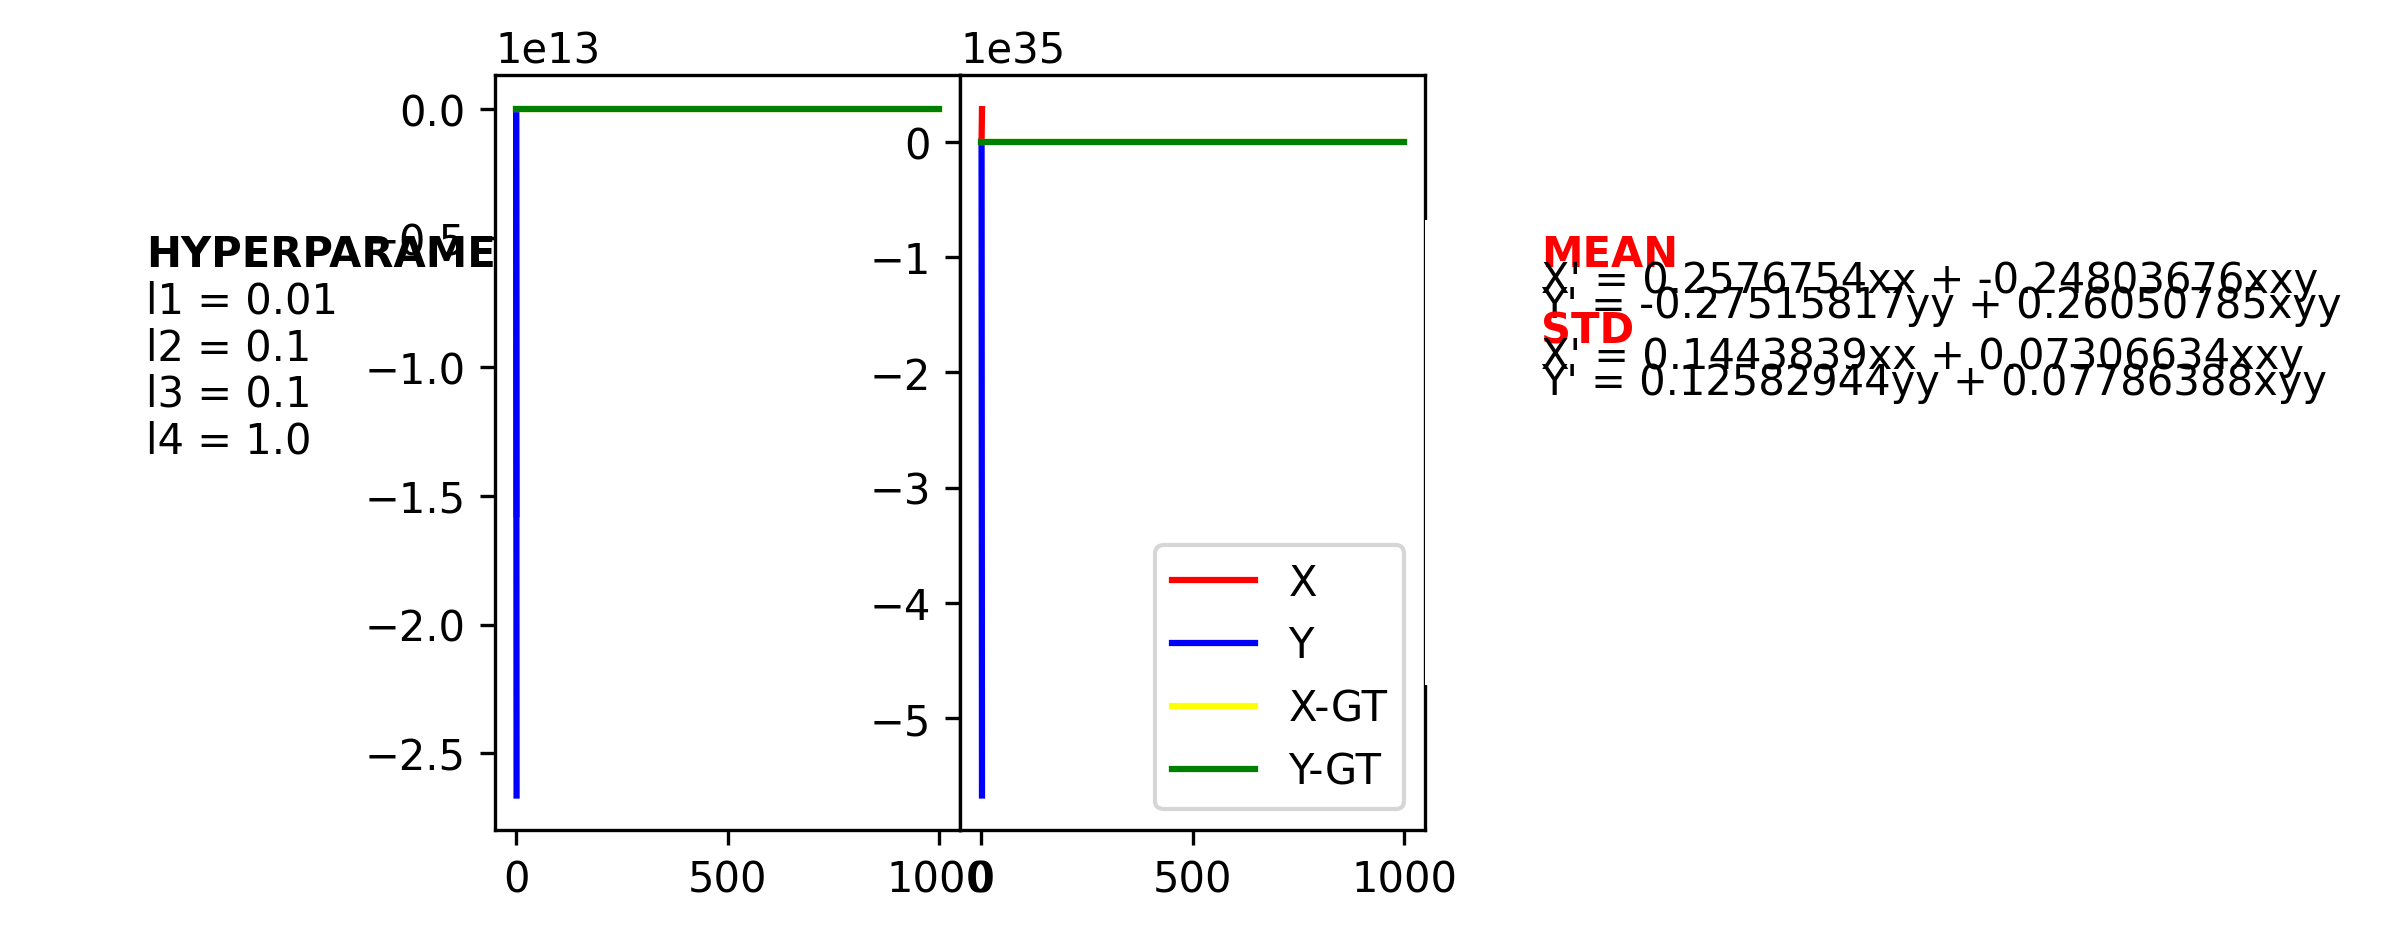

In [179]:
plot_2d_trajectory(None, train_set.x.numpy(), zs, sampled_hyperparams, equations)

In [180]:
nets[0].get_masked_coefficients(device=1).mean(0)

tensor([[ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.2579,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000, -0.2608],
        [ 0.0000,  0.0000],
        [-0.2494,  0.0000],
        [ 0.0000,  0.2525],
        [ 0.0000,  0.0000]], device='cuda:1', grad_fn=<MeanBackward1>)

In [181]:
nets[0].get_masked_coefficients(device=1).std(0)

tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.1508, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.1259],
        [0.0000, 0.0000],
        [0.0769, 0.0000],
        [0.0000, 0.0853],
        [0.0000, 0.0000]], device='cuda:1', grad_fn=<StdBackward0>)